In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import math
import json
import jax

from jax import grad
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display 

from vehicle_lib.numpy_helper import np_normalize_angle_mpi_to_pi, rotate_vector_2d
from landmark_tracking_helper import simulate_odometry_and_GPS, simulate_landmarks_sesing, Plots

/var/folders/ff/dwwznnkd5m1512lt1crp_n3m0000gn/T/ipykernel_63246/2298989038.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# Basic example to Monte Carlo Localization for a single vehicle

A basic SLAM application is considered. Herein, a single vehicle follows an unknow path passing by multiple landmarks. The positions of these landmarks are further unknown. The vehicle is equipped with sensors to measure 

* an approximate absolute position subjected to (Gaussian) noise, e.g., GPS,
* the relative movement of the vehicle as described by the velocity and yaw rate (odometry), and
* the bearing angle and distance between the vehicle body and possibly multiple landmarks.

Herein, the rate of the readings from GPS is less compared to the odometry. Further, it is assumed that all readings are subjected to Gaussian noise with known covariance parameters. Estimates for the landmark positions and the vehicle trajectory shall be derived given these measurements. Therefore, the motion model of the vehicle and models for the sensor measurements are connected in a factor graph. the unknown estimates are then determined by a nonlinear least squares procedure.

## Load a trace

This trace was produced by a vehicle model as serves as ground truth (unknown to the estimation algorithm).

In [2]:
with open('data/path_to_goal_2.json') as json_file:
    raw_trace = json.load(json_file)
    
Ts = 0.1

## Define landmark positions

In [3]:
# define landmark ground truth
pdf_landmarks_ground_truth = pd.DataFrame()

pdf_landmarks_ground_truth["landmark_id"] = np.array( [1,    2,      3], dtype=np.int64 )
pdf_landmarks_ground_truth["x"]           = np.array( [10.0, 9.0, 20.0], dtype=np.float64 )
pdf_landmarks_ground_truth["y"]           = np.array( [0.0,  5.0, 10.0], dtype=np.float64 )
pdf_landmarks_ground_truth

,landmark_id,x,y
0,1,10.0,0.0
1,2,9.0,5.0
2,3,20.0,10.0


# Generate measurement data via simulation

## Simulate the sensors for localisation of vehicle

Herein, the vehicle odometry and GPS are modelled and simulated yielding a trace of bearing measurements and GPS positions/headings.


In [4]:
pdf_odometry_measurements, pdf_gps_measurements, pdf_vehicle_trace_gt = simulate_odometry_and_GPS(
    raw_trace, number_of_samples=100, number_of_gps_samples=8,
    xy_gps_sigma  = math.sqrt( 1.0 ),
    psi_gps_sigma = math.sqrt( 0.1 ),
)

In [5]:
pdf_vehicle_trace_gt

,x,y,psi
0,24.965000,0.060622,2.111848
1,24.853632,0.238632,2.166651
2,24.732474,0.410125,2.225111
3,24.601305,0.574083,2.287212
4,24.460029,0.729413,2.352927
...,...,...,...
95,5.271301,9.132772,1.791949
96,5.222715,9.337063,1.829757
97,5.166200,9.539302,1.871167
98,5.101121,9.738947,1.916211


## Simulate the bearing/distance measurement of landmarks

In [6]:
# Simulate landmark observations
pdf_landmarks_bearing = simulate_landmarks_sesing(pdf_vehicle_trace_gt, pdf_landmarks_ground_truth)

# bearing_measurements.loc[:,'bearing_angle_sigma'] = np.deg2rad(10)
pdf_landmarks_bearing.loc[:,'bearing_angle_sigma'] = np.deg2rad(10)


## Plot the visibility of the landmarks

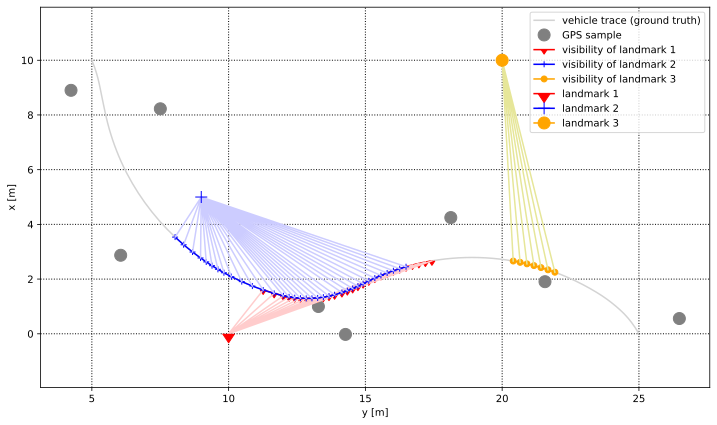

In [7]:
landmarks_to_show = [
    [1, "red",    (1.0, 0.8, 0.8), matplotlib.markers.CARETDOWNBASE ],
    [2, "blue",   (0.8, 0.8, 1.0), "+"],
    [3, "orange", (0.9, 0.9, 0.6), "o"],
]
Plots.plot_overview(pdf_vehicle_trace_gt, pdf_gps_measurements, pdf_landmarks_ground_truth, pdf_landmarks_bearing, landmarks_to_show, figsize=(12, 7))

In [8]:
pdf_odometry_measurements

,d_delta,psi_delta,d_sigma,psi_sigma
0,0.209977,0.054803,0.01,0.01
1,0.209974,0.058460,0.01,0.01
2,0.209971,0.062101,0.01,0.01
3,0.209967,0.065715,0.01,0.01
4,0.209963,0.057657,0.01,0.01
...,...,...,...,...
94,0.209997,0.022870,0.01,0.01
95,0.209989,0.037808,0.01,0.01
96,0.209987,0.041411,0.01,0.01
97,0.209985,0.045044,0.01,0.01


In [9]:
pdf_gps_measurements

,x,y,psi,index_in_trace,x_sigma,y_sigma,psi_sigma
0,26.477978,0.557671,2.112124,1,1.0,1.0,0.316228
1,21.565927,1.904642,2.485713,15,1.0,1.0,0.316228
2,18.122688,4.248713,3.188064,29,1.0,1.0,0.316228
3,14.271919,-0.023060,3.747931,43,1.0,1.0,0.316228
4,13.282317,0.997134,2.671572,57,1.0,1.0,0.316228
5,6.054188,2.870388,2.788075,71,1.0,1.0,0.316228
6,7.503783,8.225590,2.176498,85,1.0,1.0,0.316228
7,4.238793,8.900109,2.140856,99,1.0,1.0,0.316228


In [10]:
pd.set_option( 'display.max_rows', 10 )
display(pdf_landmarks_bearing.sort_values('index_in_trace_where_landmark_was_seen') )
pd.set_option( 'display.max_rows', 10 )

,landmark_id,index_in_trace_where_landmark_was_seen,bearing_angle,bearing_distance,bearing_angle_sigma,bearing_distance_sigma
0,3,16,-0.979233,7.985820,0.174533,0.4
1,3,17,-1.038304,7.841954,0.174533,0.4
2,3,18,-1.098931,7.711854,0.174533,0.4
3,3,19,-1.161027,7.596353,0.174533,0.4
4,3,20,-1.223546,7.497585,0.174533,0.4
...,...,...,...,...,...,...
30,2,68,-0.897218,2.379463,0.174533,0.4
31,2,69,-0.956539,2.228409,0.174533,0.4
32,2,70,-1.060340,2.035893,0.174533,0.4
33,2,71,-1.208867,1.860661,0.174533,0.4


In [11]:
def read_odometry_measurement(pdf_odometry_measurements, k):
    pdf_odometry = pdf_odometry_measurements[ pdf_odometry_measurements.index == k ]
    #pdf_odometry
    Ts = 0.1

    u = jnp.array([
        pdf_odometry.d_delta.item() / Ts,
        pdf_odometry.psi_delta.item() / Ts,
    ])
    
    return u


def read_bearings_and_landmarks( pdf_landmarks_bearing_sorted, pdf_landmarks_ground_truth, k):
    
    bearing_measurements_ = pdf_landmarks_bearing_sorted[ 
        pdf_landmarks_bearing_sorted.index_in_trace_where_landmark_was_seen == k 
    ]
    
    # lookup the position of the landmark in the map
    bearing_measurements = (
        bearing_measurements_
        .merge( pdf_landmarks_ground_truth, left_on='landmark_id', right_on='landmark_id', how='left' )
        .rename( columns={ 'x': 'x_landmark', 'y': 'y_landmark' } )
    )
    
    return bearing_measurements
                                                                                                                        
    
    

In [12]:
# loop

assert pdf_odometry_measurements.index.min() == 0
n = pdf_odometry_measurements.index.max()

pdf_landmarks_bearing_sorted = pdf_landmarks_bearing.sort_values('index_in_trace_where_landmark_was_seen')

for k in [44]: # range(n):
    # time sample k
    # print(k)
    
    odometry_measurement = pdf_odometry_measurements.iloc[k]
    
    # odometry_measurement.d_delta
    # odometry_measurement.psi_delta
    
    bearing_measurements = read_bearings_and_landmarks( pdf_landmarks_bearing_sorted, pdf_landmarks_ground_truth, k)
    
#    bearing_measurements = pdf_landmarks_bearing_sorted[ 
#        pdf_landmarks_bearing_sorted.index_in_trace_where_landmark_was_seen == k 
#    ]
    
    
bearing_measurements

,landmark_id,index_in_trace_where_landmark_was_seen,bearing_angle,bearing_distance,bearing_angle_sigma,bearing_distance_sigma,x_landmark,y_landmark
0,2,44,-0.913738,6.847994,0.174533,0.4,9.0,5.0
1,1,44,-0.088604,5.477355,0.174533,0.4,10.0,0.0


In [13]:

def bearing_model(X_hat, x_landmark, y_landmark):
    # bearing model


    # 
    # x_landmark_hat = x_hat + bearing_distance * cos( bearing_angle )
    #
    # bearing_angle_mdl    = atan2(y_landmark - y_hat, x_landmark - x_hat) - psi_hat
    # bearing_distance_mdl = sqrt( (x_landmark - x_hat)^2 + (y_landmark - y_hat)^2 )
    #
    #

    x_hat = X_hat[:,0]
    y_hat = X_hat[:,1]
    psi_hat = X_hat[:,2]

    bearing_angle    = jnp.arctan2( y_landmark - y_hat, x_landmark - x_hat ) - psi_hat
    bearing_distance = jnp.linalg.norm( 
        jnp.array( [y_landmark - y_hat, x_landmark - x_hat] ),
        axis=0
    )

    return bearing_angle, bearing_distance



# test
X_hat = jnp.array([
      [1.0, 1.0, 0.0], # xypsi_hat_1
      [0.0, 0.0, np.deg2rad(45.0)], # xypsi_hat_2
      [0.0, 0.0, np.deg2rad(-45.0)], # xypsi_hat_2
])

x_landmark = 3.0
y_landmark = 3.0

bearing_angle, bearing_distance = bearing_model(X_hat, x_landmark, y_landmark)

x_hat = X_hat[:,0]
y_hat = X_hat[:,1]
psi_hat = X_hat[:,2]

assert np.rad2deg(bearing_angle)[0] == 45
assert np.rad2deg(bearing_angle)[1] == 0
assert np.rad2deg(bearing_angle)[2] == 90

dist1 = math.sqrt( (x_landmark - x_hat[0].item() )**2 + (y_landmark - y_hat[0].item() )**2 )
assert np.abs(bearing_distance[0].item() - dist1) < 0.0001

dist2 = math.sqrt( (x_landmark - x_hat[1].item() )**2 + (y_landmark - y_hat[1].item() )**2 )
assert np.abs(bearing_distance[1].item() - dist2) < 0.0001

dist3 = math.sqrt( (x_landmark - x_hat[2].item() )**2 + (y_landmark - y_hat[2].item() )**2 )
assert np.abs(bearing_distance[1].item() - dist3) < 0.0001


np.rad2deg(bearing_angle)
bearing_distance

DeviceArray([2.828427 , 4.2426405, 4.2426405], dtype=float32)

In [14]:
def angle_diff( ang1, ang2 ):
    d = ang1 - ang2
    return ( d + np.pi ) % (2 * np.pi) - np.pi

def measurement_model_likelihood(
    X_hat, 
    x_landmark, y_landmark, 
    bearing_angle_measurement, bearing_distance_measurement, 
    sigma_angle, sigma_distance
):
    """
        for a sigle landmark and a single measurement 
    """

    bearing_angle, bearing_distance = bearing_model(X_hat, x_landmark, y_landmark)
    
    residual_angle    = angle_diff(bearing_angle, bearing_angle_measurement)
    residual_distance = bearing_distance - bearing_distance_measurement
    
    likelihood_bearing_angle    = jax.scipy.stats.norm.pdf( residual_angle,    scale=sigma_angle    )
    likelihood_bearing_distance = jax.scipy.stats.norm.pdf( residual_distance, scale=sigma_distance )
    
    return likelihood_bearing_angle, likelihood_bearing_distance, residual_angle, residual_distance
 
    
    
# test
X_hat = jnp.array([
      [1.0, 1.0, 0.0], # xypsi_hat_1
      [0.0, 0.0, np.deg2rad(45.0)], # xypsi_hat_2
      [0.0, 0.0, np.deg2rad(-45.0)], # xypsi_hat_2
])
    
    
x_landmark = 3.0
y_landmark = 3.0

bearing_angle_measurement    = jnp.array( 0.0 )
bearing_distance_measurement = jnp.array( dist2 )

sigma_angle, sigma_distance  = np.deg2rad(40), 0.1


likelihood_bearing_angle, likelihood_bearing_distance, residual_angle, residual_distance = measurement_model_likelihood(
    X_hat, 
    x_landmark, y_landmark, 
    bearing_angle_measurement, bearing_distance_measurement, 
    sigma_angle, sigma_distance
)

# pose at index = 1 shall fitting the best
assert jnp.argmax(likelihood_bearing_angle) == 1
assert jnp.argmax(likelihood_bearing_distance) == 1

#likelihood_bearing_angle
(residual_angle, residual_distance)


(DeviceArray([0.78539824, 0.        , 1.5707963 ], dtype=float32),
 DeviceArray([-1.4142134,  0.       ,  0.       ], dtype=float32))

In [15]:
likelihood_bearing_angle, likelihood_bearing_distance

(DeviceArray([0.3034909 , 0.5714427 , 0.04546371], dtype=float32),
 DeviceArray([0.       , 3.9894226, 3.9894226], dtype=float32))

In [16]:
np.rad2deg( bearing_measurements.bearing_angle_sigma.iloc[0] )

10.0

In [17]:
# get the correct vehicle position for the observation in bearing_measurements
tmp = pdf_vehicle_trace_gt[ pdf_vehicle_trace_gt.index == bearing_measurements.index_in_trace_where_landmark_was_seen.iloc[0] ]

X_hat = jnp.array([
      [tmp.x.item(), tmp.y.item(), tmp.psi.item()],
])

X_hat[0, 0:2], np.rad2deg( X_hat[0, 2] )

(DeviceArray([15.12401  ,  1.9354409], dtype=float32), 205.76915)

In [18]:
landmark_index = 1

likelihood_bearing_angle, likelihood_bearing_distance, residual_angle, residual_distance = measurement_model_likelihood(
    X_hat, 
    bearing_measurements.x_landmark.iloc[landmark_index], 
    bearing_measurements.y_landmark.iloc[landmark_index], 
    
    bearing_measurements.bearing_angle.iloc[landmark_index],
    bearing_measurements.bearing_distance.iloc[landmark_index],

    bearing_measurements.bearing_angle_sigma.iloc[landmark_index], 
    bearing_measurements.bearing_distance_sigma.iloc[landmark_index],
)

likelihood_bearing_angle * likelihood_bearing_distance

#np.rad2deg(residual_angle )

DeviceArray([2.2797267], dtype=float32)

In [19]:
def convert_measurements_and_landmark_positions_to_jnp_array(bearing_measurements : pd.DataFrame) -> jnp.DeviceArray:

    # convert measurements and the known landmark position into jnp arrays
    P = jnp.array([
        bearing_measurements.x_landmark,
        bearing_measurements.y_landmark,

        bearing_measurements.bearing_angle, 
        bearing_measurements.bearing_distance,
        
        bearing_measurements.bearing_angle_sigma,
        bearing_measurements.bearing_distance_sigma,
        
    ]).T

    return P

P = convert_measurements_and_landmark_positions_to_jnp_array(bearing_measurements)
P

DeviceArray([[ 9.        ,  5.        , -0.91373795,  6.8479943 ,
               0.17453292,  0.4       ],
             [10.        ,  0.        , -0.08860362,  5.4773545 ,
               0.17453292,  0.4       ]], dtype=float32)

In [20]:
def for_each_landmark_and_particle(X_hat, P):

    def fn(i, inp):
        X_hat = inp['X_hat']
        likelihood_agg_per_particle = inp['likelihood_agg_per_particle']
        P = inp['P']

        # for each landmark i
        x_landmark = P[i, 0]
        y_landmark = P[i, 1]

        bearing_angle_measurement = P[i, 2]
        bearing_distance_measurement = P[i, 3]

        bearing_angle_sigma    = P[i,4]
        bearing_distance_sigma = P[i,5]


        #
        likelihood_bearing_angle, likelihood_bearing_distance, residual_angle, residual_distance = measurement_model_likelihood(
            X_hat, 
            x_landmark, y_landmark, 
            bearing_angle_measurement, bearing_distance_measurement, 
            bearing_angle_sigma, bearing_distance_sigma
        )

        likelihood = likelihood_bearing_angle * likelihood_bearing_distance
        likelihood_agg_per_particle = likelihood_agg_per_particle * likelihood

        return { 
            'X_hat': X_hat, 
            'likelihood_agg_per_particle': likelihood_agg_per_particle, 
            'P' : P, 
        }


    n_particles = X_hat.shape[0]
    n = P.shape[0]
    likelihood_agg_per_particle = jnp.ones( n_particles )
    likelihood_per_landmark = jnp.zeros( n )

    ret = fori_loop(
        0,n, fn, 
        {
            'X_hat': X_hat, 
            'likelihood_agg_per_particle' : likelihood_agg_per_particle, 
            'P' : P, 
        }
    )

    return ret['likelihood_agg_per_particle'], ret


likelihood_per_particle, ret = for_each_landmark_and_particle(X_hat, P)
#jnp.max( ret['likelihood_agg_per_particle'] )
ret

{'P': DeviceArray([[ 9.        ,  5.        , -0.91373795,  6.8479943 ,
                0.17453292,  0.4       ],
              [10.        ,  0.        , -0.08860362,  5.4773545 ,
                0.17453292,  0.4       ]], dtype=float32),
 'X_hat': DeviceArray([[15.12401  ,  1.9354409,  3.5913494]], dtype=float32),
 'likelihood_agg_per_particle': DeviceArray([5.197154], dtype=float32)}

In [21]:
def init_rand():
    seed = 1701
    rkey = jax.random.PRNGKey(seed)

    return rkey

def sample_normal( rkey, n, n_dim=3, mu=0, sigma=1 ):

    shape = (n, n_dim)
    
    samples = jax.random.normal( rkey, shape  ) * sigma + mu
    rkey, rkey_next = jax.random.split(rkey)
    
    return rkey, samples

def sample_uniform( rkey, n, n_dim=3 ):

    shape = (n, n_dim)

    samples = jax.random.uniform( rkey, shape )
    rkey, rkey_next = jax.random.split(rkey)
    
    return rkey, samples

rkey = init_rand()

In [22]:

# generate uniformly distributed paricles
def generate_initial_particles(rkey, n_particles=1000000, x_max=25.0, y_max=10.0):

    rkey, X_hat_ = sample_uniform( rkey, n_particles, n_dim=3 )

    X_hat = jnp.array([
        X_hat_[:,0] * x_max,
        X_hat_[:,1] * y_max,
        X_hat_[:,2] * 2 * math.pi,
    ]).T
    
    weights = jnp.ones( n_particles ) / n_particles
    
    return rkey, X_hat, weights


rkey, X_hat, weights = generate_initial_particles(rkey, n_particles=1000000, x_max=25.0, y_max=10.0)

likelihood_per_particle, _ = for_each_landmark_and_particle(X_hat, P)


In [23]:

def fiter_particles_with_significant_likelihood(X_hat, likelihood_per_particle):
    max_likelihood = jnp.max( likelihood_per_particle )
    I_significant_likelihood = jnp.where( likelihood_per_particle > 0.01 * max_likelihood )[0]

    likelihood_agg_per_particle = likelihood_per_particle[I_significant_likelihood]
    X_hat = X_hat[I_significant_likelihood]
    
    return likelihood_agg_per_particle, X_hat, I_significant_likelihood
    
    
likelihood_agg_per_particle_significant, X_hat_significant, I_significant_likelihood = fiter_particles_with_significant_likelihood(X_hat, likelihood_per_particle)



In [24]:
def resample(rkey, X_hat, weights):
    n_particles = X_hat.shape[0]

    cumulative_sum = jnp.cumsum(weights)
    cumulative_sum = cumulative_sum.at[-1].set(1)

    rkey, r = sample_uniform( rkey, n_particles, n_dim=1 )
    r = r[:,0]

    indices = jnp.searchsorted(cumulative_sum, r)

    X_hat = X_hat[indices]
    weights = jnp.ones(n_particles) * 1.0 / n_particles 

    return rkey, X_hat, weights


#rkey, X_hat, weights = resample(rkey, X_hat, weights)

In [25]:
def estimate(X_hat, weights):
    """returns mean and variance of the weighted particles"""

#    pos = particles[:, 0:2]
    mean = np.average(X_hat, weights=weights, axis=0)
    var  = np.average( (X_hat - mean)**2, weights=weights, axis=0)
    
    return mean, var


mean, var = estimate(X_hat, likelihood_per_particle)
mean, var

(array([15.096261 ,  1.9339588,  3.5864813], dtype=float32),
 array([0.09837911, 0.4919352 , 0.02690468], dtype=float32))

In [26]:

def plot_particles(X_hat, weight):
                   
    # plot particles; color is depending on the likelihood

    f, (ax1 ) = plt.subplots(1, 1, figsize=(6,6), dpi=100)

    ax1.grid()
    ax1.set_aspect('equal')

    I_sort = jnp.argsort( weight )
    
    ax1.scatter( 
        X_hat[I_sort,0], 
        X_hat[I_sort,1], 
        c=weight[I_sort],
        s=40, marker='+', cmap='binary'
    )

def plot_particles3(ax, X_hat, weight):
                   
    # plot particles; color is depending on the likelihood

    I_sort = jnp.argsort( weight )
    
    ax.scatter( 
        X_hat[I_sort,0], 
        X_hat[I_sort,1], 
        c=weight[I_sort],
        s=40, marker='+', cmap='binary'
    )
    
def plot_particles2(X_hat, weight, color_coding=True):
                   
    # plot particles; color is depending on the likelihood


    I_sort = jnp.argsort( weight )
    
    color = weight[I_sort] if color_coding else None
    
    plt.scatter( 
        X_hat[I_sort,0], 
        X_hat[I_sort,1], 
        c=color,
        s=40, marker='+', cmap='binary'
    )
    

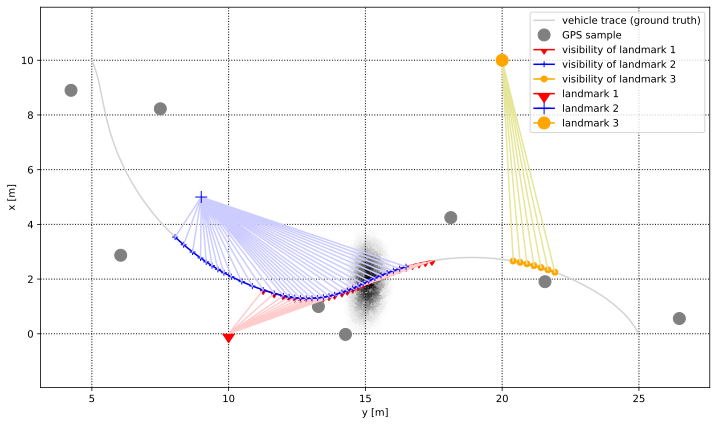

In [27]:

landmarks_to_show = [
    [1, "red",    (1.0, 0.8, 0.8), matplotlib.markers.CARETDOWNBASE ],
    [2, "blue",   (0.8, 0.8, 1.0), "+"],
    [3, "orange", (0.9, 0.9, 0.6), "o"],
]
Plots.plot_overview(pdf_vehicle_trace_gt, pdf_gps_measurements, pdf_landmarks_ground_truth, pdf_landmarks_bearing, landmarks_to_show, figsize=(12, 7))

plot_particles2(X_hat_significant, likelihood_agg_per_particle_significant)


In [28]:
jnp.arange(0, 10, 3)

DeviceArray([0, 3, 6, 9], dtype=int32)

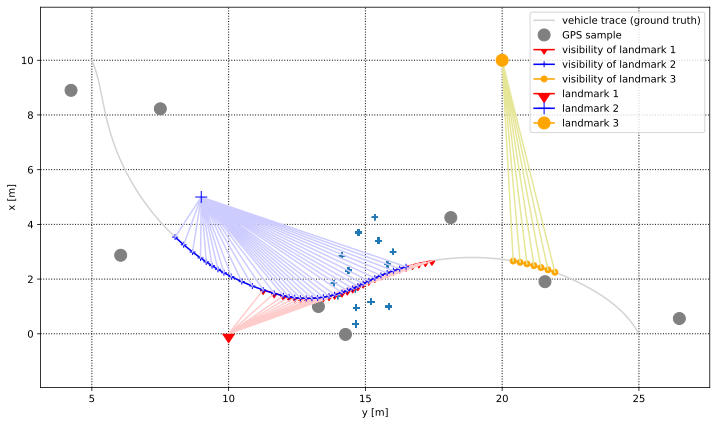

In [29]:
# resample

rkey, X_hat_resampled, weights_resampled = resample(rkey, X_hat, likelihood_per_particle)


landmarks_to_show = [
    [1, "red",    (1.0, 0.8, 0.8), matplotlib.markers.CARETDOWNBASE ],
    [2, "blue",   (0.8, 0.8, 1.0), "+"],
    [3, "orange", (0.9, 0.9, 0.6), "o"],
]
Plots.plot_overview(pdf_vehicle_trace_gt, pdf_gps_measurements, pdf_landmarks_ground_truth, pdf_landmarks_bearing, landmarks_to_show, figsize=(12, 7))

indices_subsample = jnp.arange(0, X_hat_resampled.shape[0], 500)
plot_particles2(X_hat_resampled[indices_subsample], weights_resampled[indices_subsample], color_coding=False)


In [30]:
def transition_function( X, u, Ts = 0.1 ):
    """
        x[:,0] - x positions
        x[:,1] - y positions
        x[:,2] - psi orientations
        
        u[0] - velocity
        u[1] - angular velocity
        
    """
    
#    X_next = jnp.zeros_like(X)
    
    X0_next = X[:,0] + Ts * jnp.cos( X[:,2] ) * u[:,0]
    X1_next = X[:,1] + Ts * jnp.sin( X[:,2] ) * u[:,0]
    X2_next = X[:,2] + Ts * u[:,1] # add modulo
    
    return jnp.array( [X0_next, X1_next, X2_next] ).T


In [31]:
# get odometry measurement

def prediction_step(rkey, X_hat, u, Ts):
    n_particles = X_hat.shape[0]
    U = jnp.ones( (n_particles, 2) ) * u
    X_hat_next = transition_function( X_hat, U, Ts )

    return rkey, X_hat_next


u = read_odometry_measurement(pdf_odometry_measurements, k)
rkey, X_hat_next = prediction_step(rkey, X_hat, u, Ts)

X_hat_next - X_hat

DeviceArray([[-0.21612358,  0.08460045,  0.00900745],
             [-0.01490021, -0.23161316,  0.00900745],
             [-0.05972672,  0.22427523,  0.00900745],
             ...,
             [-0.16358948,  0.1646359 ,  0.00900745],
             [-0.00715446, -0.23198152,  0.00900745],
             [ 0.17006898,  0.15793419,  0.00900745]], dtype=float32)

In [32]:
u

DeviceArray([2.320919  , 0.09007474], dtype=float32)

In [33]:
n_particles = X_hat.shape[0]

def add_noise_to_control(rkey, u, n_particles, sigma_1=0.2, sigma_2=np.deg2rad(10) ):
    
    rkey, noise_1_ = sample_normal(rkey, n_particles, n_dim=1, sigma=sigma_1)
    noise_1 = noise_1_[:,0]

    rkey, noise_2_ = sample_normal(rkey, n_particles, n_dim=1, sigma=np.deg2rad( 5 ) )
    noise_2 = noise_2_[:,0]

    u_noise = jnp.array([
        noise_1,
        noise_2,
    ]).T + jnp.ones( (n_particles, 2) )* u

    return rkey, u_noise

rkey, u_noise = add_noise_to_control(rkey, u, n_particles)

# algorithm

In [34]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [40]:
# loop

assert pdf_odometry_measurements.index.min() == 0
n = pdf_odometry_measurements.index.max()

pdf_landmarks_bearing_sorted = pdf_landmarks_bearing.sort_values('index_in_trace_where_landmark_was_seen')


rkey = init_rand()
rkey, X_hat, weights = generate_initial_particles(rkey, n_particles=10000, x_max=25.0, y_max=10.0)


n_samples = pdf_odometry_measurements.shape[0]


X_estimated_trace = np.zeros( (n_samples, X_hat.shape[1]) )

significant_particles_trace = [ None for i in range(n) ]

for k in range(0,n):
    #
    # at time sample k
    #
    
    n_particles = X_hat.shape[0]
    
    # read
    u = read_odometry_measurement(pdf_odometry_measurements, k)
    bearing_measurements = read_bearings_and_landmarks( pdf_landmarks_bearing_sorted, pdf_landmarks_ground_truth, k)
    P = convert_measurements_and_landmark_positions_to_jnp_array(bearing_measurements)
    
    n_visible_landmarks = P.shape[0]
    print("k", k, "n_visible_landmarks", n_visible_landmarks)
    
    # add gaussian noise to the odometry/control u
    
    # predict
    rkey, u_noise = add_noise_to_control(rkey, u, n_particles, sigma_1=0.4, sigma_2=np.deg2rad(20))
    rkey, X_hat_next = prediction_step(rkey, X_hat, u_noise, Ts)
    
    if n_visible_landmarks > 0:

        # apply measurement model
        likelihood_per_particle, _ = for_each_landmark_and_particle(X_hat_next, P)
                
        # Bayes
        weights_ = weights * likelihood_per_particle
        weights = weights_ / jnp.sum(weights_)

        
    # analyse
    likelihood_agg_per_particle_significant, X_hat_significant, I_significant_likelihood = fiter_particles_with_significant_likelihood(X_hat_next, weights)        
    significant_particles_trace[k] = [ X_hat_significant, likelihood_agg_per_particle_significant ]
        
    if neff(weights) < n_particles / 2:

        # resample
        print("resample")
        rkey, X_hat_next, weights = resample(rkey, X_hat_next, weights)
    
    #
    mean, var = estimate(X_hat_next, weights)
    
    X_estimated_trace[k, :] = mean if np.max(var) < 2.0 else math.nan

    #print("position", mean[0:2], "ori", np.rad2deg(mean[2]), "variances", var)
    
    #
    X_hat = X_hat_next

    
#bearing_measurements
#u

k 0 n_visible_landmarks 0
k 1 n_visible_landmarks 0
k 2 n_visible_landmarks 0
k 3 n_visible_landmarks 0
k 4 n_visible_landmarks 0
k 5 n_visible_landmarks 0
k 6 n_visible_landmarks 0
k 7 n_visible_landmarks 0
k 8 n_visible_landmarks 0
k 9 n_visible_landmarks 0
k 10 n_visible_landmarks 0
k 11 n_visible_landmarks 0
k 12 n_visible_landmarks 0
k 13 n_visible_landmarks 0
k 14 n_visible_landmarks 0
k 15 n_visible_landmarks 0
k 16 n_visible_landmarks 1
resample
k 17 n_visible_landmarks 1
k 18 n_visible_landmarks 1
k 19 n_visible_landmarks 1
resample
k 20 n_visible_landmarks 1
k 21 n_visible_landmarks 1
k 22 n_visible_landmarks 1
k 23 n_visible_landmarks 0
k 24 n_visible_landmarks 0
k 25 n_visible_landmarks 0
k 26 n_visible_landmarks 0
k 27 n_visible_landmarks 0
k 28 n_visible_landmarks 0
k 29 n_visible_landmarks 0
k 30 n_visible_landmarks 0
k 31 n_visible_landmarks 0
k 32 n_visible_landmarks 0
k 33 n_visible_landmarks 0
k 34 n_visible_landmarks 1
resample
k 35 n_visible_landmarks 1
k 36 n_visi

(9999, 3)

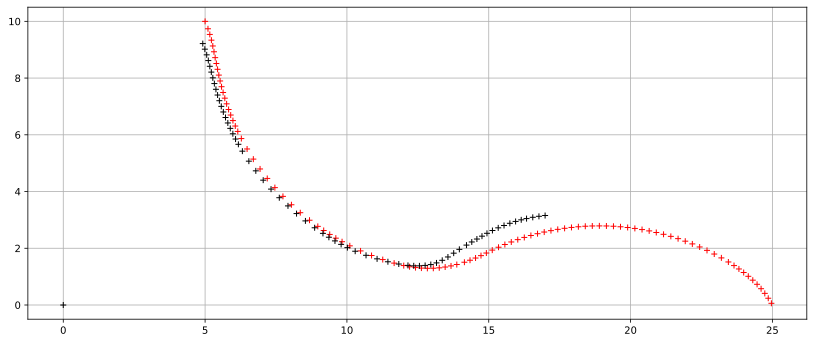

In [41]:
#

k = 67

f, (ax1 ) = plt.subplots(1, 1, figsize=(14,6), dpi=100)

ax1.grid()
ax1.set_aspect('equal')

ax1.plot(pdf_vehicle_trace_gt.x, pdf_vehicle_trace_gt.y, '+', color="red", label="")
ax1.plot( X_estimated_trace[:,0], X_estimated_trace[:,1], '+', color="black", label="")


if significant_particles_trace[k] is not None:
    #plot_particles3(ax1, significant_particles_trace[k][0], significant_particles_trace[k][1] )
    pass

significant_particles_trace[k][0].shape

In [37]:
significant_particles_trace[0]

[DeviceArray([[18.131704 ,  2.2165399,  1.067074 ],
              [14.610893 ,  8.453341 ,  1.6287616],
              [20.11324  ,  4.6401215,  3.9631665],
              ...,
              [22.18937  ,  4.939077 ,  3.779306 ],
              [ 1.5521144,  4.3456717,  5.0418463],
              [21.62881  ,  5.6287513,  2.415771 ]], dtype=float32),
 DeviceArray([2.e-07, 2.e-07, 2.e-07, ..., 2.e-07, 2.e-07, 2.e-07], dtype=float32)]

In [38]:

X_hat   = significant_particles_trace[20][1]
weights = significant_particles_trace[20][0]
